# Validation on all external validation datasets

In [1]:
import pandas as pd
import numpy as np
import pickle

from src.config.paths import (
    DNN_DIR,
    BENCHMARKING_DIR,
    SKLEARN_DIR,
    VALIDATION_COMBINED_DIR,
    VALIDATION_SCOTLAND_DIR,
    VALIDATION_AUSTRALIA_DIR,
    VALIDATION_SPAIN_DIR,
    ensure_output_dirs,
)
from src.data.loading import load_sklearn_models_and_metadata, load_dnn_model
from src.data.validation import (
    evaluate_model,
    prepare_logreg_data,
    plot_roc_curve,
    plot_confusion_matrix,
    create_metrics_dict,
    plot_combined_roc_curves,
    plot_model_agreement_heatmap,
)
from src.models.delong import delong_roc_test

ensure_output_dirs()


## Config

In [2]:
output_dir = VALIDATION_COMBINED_DIR
sklearn_models_dir = SKLEARN_DIR / "exports"

## Load Validation Data and Models

In [3]:
# Load the validation datasets
# Load Spain data
X_spain = pd.read_csv(VALIDATION_SPAIN_DIR / "X_spain.csv")
y_spain = pd.read_csv(VALIDATION_SPAIN_DIR / "y_spain.csv").squeeze()

# Load combined data
X_scotland = pd.read_csv(VALIDATION_SCOTLAND_DIR / "X_scotland.csv")
y_scotland = pd.read_csv(VALIDATION_SCOTLAND_DIR / "y_scotland.csv").squeeze()

# Load Australia data
X_australia = pd.read_csv(VALIDATION_AUSTRALIA_DIR / "X_australia.csv")
y_australia = pd.read_csv(VALIDATION_AUSTRALIA_DIR / "y_australia.csv").squeeze()

# Combine the datasets with a new column indicating the source
X_spain["validation_source"] = "Spain"
X_scotland["validation_source"] = "Scotland"
X_australia["validation_source"] = "Australia"

# Combine X and y data
X_combined = pd.concat([X_spain, X_scotland, X_australia], ignore_index=True)
y_combined = pd.concat([y_spain, y_scotland, y_australia], ignore_index=True)


# Print dataset sizes
print(f"Spain dataset: {len(X_spain)} samples")
print(f"Scotland dataset: {len(X_scotland)} samples")
print(f"Australia dataset: {len(X_australia)} samples")
print(f"Combined dataset: {len(X_combined)} samples")


Spain dataset: 101 samples
Scotland dataset: 61 samples
Australia dataset: 90 samples
Combined dataset: 252 samples


In [4]:
# Get the validation source for reference
validation_source = X_combined["validation_source"].copy()
X_combined = X_combined.drop(columns=["validation_source"])
# Verify all datasets have the same columns
print(
    f"Columns match between all datasets: {set(X_spain.columns) == set(X_combined.columns) == set(X_australia.columns)}"
)

Columns match between all datasets: False


In [5]:
target_df = pd.read_csv(DNN_DIR / "exports" / "X_test.csv")

In [6]:
# Load the model, scaler, and explainer
model, scaler, explainer = load_dnn_model(model_date="2025-04-24")

/Users/chershiongchuah/Developer/machine_learning_for_ibd_fatigue/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
# Load all sklearn models
print("Loading scikit-learn models...")
sklearn_models, sklearn_scaler, sklearn_feature_names = (
    load_sklearn_models_and_metadata(sklearn_models_dir)
)

Loading scikit-learn models...


In [8]:
# Load the logistic regression model
try:
    with open(BENCHMARKING_DIR / "statsmodels_logreg.pkl", "rb") as f:
        logreg_model = pickle.load(f)
    logreg_loaded = True
except FileNotFoundError:
    print("Warning: Logistic regression model file not found.")
    logreg_loaded = False
except Exception as e:
    print(f"Error loading or predicting with logistic regression model: {e}")
    logreg_loaded = False

## Check Validation Data Matches Input Data

In [9]:
# Verify feature compatibility
sklearn_features_set = set(sklearn_feature_names)
combined_features_set = set(X_combined.columns)
if missing := (sklearn_features_set - combined_features_set):
    print(f"Warning: Missing features in Scottish data: {missing}")
if extra := (combined_features_set - sklearn_features_set):
    print(f"Warning: Extra features in Scottish data: {extra}")

print(
    f"Loaded {len(sklearn_models)} sklearn models: {', '.join(sklearn_models.keys())}"
)

Loaded 6 sklearn models: Svc, Mlpclassifier, Xgboost, Random Forest, Adaboost, Logistic Regression


In [10]:
X_combined_columns_not_in_target_df = set(X_combined.columns) - set(target_df.columns)
print(f"Columns in X_combined not in target_df: {X_combined_columns_not_in_target_df}")

target_df_columns_not_in_X_combined = set(target_df.columns) - set(X_combined.columns)
print(f"Columns in target_df not in X_combined: {target_df_columns_not_in_X_combined}")

Columns in X_combined not in target_df: set()
Columns in target_df not in X_combined: set()


## Initialise Results Container

In [11]:
all_model_results = {}

## Evaluating DNN Model

In [12]:
# Evaluate model
y_pred_proba, y_pred, roc_auc, fpr, tpr, cm, metrics_dnn = evaluate_model(
    X_combined, y_combined, model
)

# Save results
all_model_results["Deep Neural Network"] = {
    "fpr": fpr,
    "tpr": tpr,
    "auc": roc_auc,
    "confusion_matrix": cm,
    "metrics": metrics_dnn,
    "predictions": y_pred,
    "probabilities": y_pred_proba,
    "color": "darkorange",
}

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


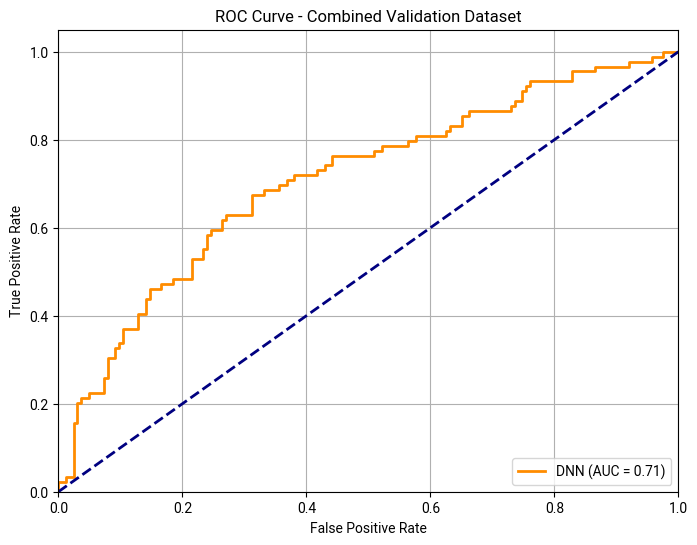

In [13]:
plot_roc_curve(
    fpr,
    tpr,
    roc_auc,
    title="ROC Curve - Combined Validation Dataset",
    save_path=output_dir / "roc_curve_combined.png",
)

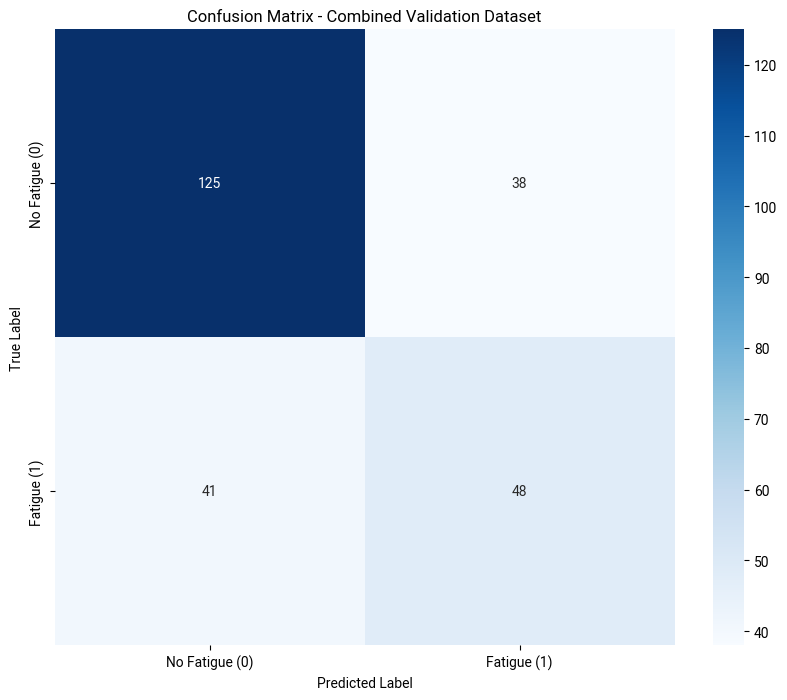

In [14]:
plot_confusion_matrix(
    cm,
    title="Confusion Matrix - Combined Validation Dataset",
    save_path=output_dir / "confusion_matrix_combined.png",
)

## Evaluating Logistic Regression Model

In [15]:
if logreg_loaded:
    X_combined_const = prepare_logreg_data(X_combined, logreg_model)
    (
        y_pred_proba_logreg,
        y_pred_logreg,
        roc_auc_logreg,
        fpr_logreg,
        tpr_logreg,
        cm_logreg,
        metrics_logreg,
    ) = evaluate_model(X_combined_const, y_combined, logreg_model)

    all_model_results["Logistic Regression (statsmodels)"] = {
        "fpr": fpr_logreg,
        "tpr": tpr_logreg,
        "auc": roc_auc_logreg,
        "confusion_matrix": cm_logreg,
        "metrics": metrics_logreg,
        "predictions": y_pred_logreg,
        "probabilities": y_pred_proba_logreg,
        "color": "blue",
    }

## Evaluating SKLearn Models

In [16]:
for model_name, model in sklearn_models.items():
    print(f"Evaluating {model_name}...")
    (
        y_pred_proba_sklearn,
        y_pred_sklearn,
        roc_auc_sklearn,
        fpr_sklearn,
        tpr_sklearn,
        cm_sklearn,
        metrics_sklearn,
    ) = evaluate_model(X_combined, y_combined, model)

    # Save results
    all_model_results[model_name] = {
        "fpr": fpr_sklearn,
        "tpr": tpr_sklearn,
        "auc": roc_auc_sklearn,
        "confusion_matrix": cm_sklearn,
        "metrics": metrics_sklearn,
        "predictions": y_pred_sklearn,
        "probabilities": y_pred_proba_sklearn,
        "color": None,
    }

Evaluating Svc...
Evaluating Mlpclassifier...
Evaluating Xgboost...
Evaluating Random Forest...
Evaluating Adaboost...
Evaluating Logistic Regression...


## Calculate All Model Metrics

In [17]:
model_metrics = [
    create_metrics_dict(name, results["metrics"])
    for name, results in all_model_results.items()
]

# Create dataframe and sort by AUC
metrics_df = pd.DataFrame(model_metrics).sort_values("AUC", ascending=False)
metrics_df = metrics_df.round(3)

# Display metrics
print("Model Performance on Combined Validation Dataset:")
print(metrics_df)

# Save metrics to CSV
metrics_df.to_csv(output_dir / "combined_validation_metrics.csv", index=False)
print(f"Metrics saved to {output_dir / 'combined_validation_metrics.csv'}")

Model Performance on Combined Validation Dataset:
                               Model    AUC  Accuracy  Sensitivity  \
7                Logistic Regression  0.735     0.726        0.461   
3                      Mlpclassifier  0.734     0.734        0.427   
2                                Svc  0.719     0.726        0.517   
0                Deep Neural Network  0.710     0.687        0.539   
1  Logistic Regression (statsmodels)  0.709     0.698        0.438   
6                           Adaboost  0.699     0.667        0.258   
4                            Xgboost  0.689     0.694        0.371   
5                      Random Forest  0.677     0.694        0.360   

   Specificity  Positive Predictive Value  Negative Predictive Value  \
7        0.871                      0.661                      0.747   
3        0.902                      0.704                      0.742   
2        0.840                      0.639                      0.761   
0        0.767                 

In [22]:
# DeLong's test comparing top AUC model to others on combined validation
delong_inputs = {}
for model_name, results in all_model_results.items():
    scores = results['probabilities']
    if hasattr(scores, 'ravel'):
        scores = scores.ravel()
    delong_inputs[model_name] = {
        'y_true': y_combined.to_numpy(),
        'y_score': scores,
    }

top_model = metrics_df.iloc[0]['Model']
delong_rows = []
for model_name, data in delong_inputs.items():
    if model_name == top_model:
        continue
    result = delong_roc_test(
        delong_inputs[top_model]['y_true'],
        delong_inputs[top_model]['y_score'],
        data['y_score'],
    )
    delong_rows.append(
        {
            'Model A': top_model,
            'Model B': model_name,
            'AUC A': result['aucs'][0],
            'AUC B': result['aucs'][1],
            'Z-Score': result['z_score'],
            'p-value': result['p_value'],
        }
    )

delong_df = pd.DataFrame(delong_rows)
delong_df = delong_df.round(3)
print(delong_df)

delong_save_path = output_dir / 'delong_comparisons.csv'
delong_save_path.parent.mkdir(parents=True, exist_ok=True)
delong_df.to_csv(delong_save_path, index=False)
print(f"DeLong test results saved to {delong_save_path}")


               Model A                            Model B  AUC A  AUC B  \
0  Logistic Regression                Deep Neural Network  0.735  0.710   
1  Logistic Regression  Logistic Regression (statsmodels)  0.735  0.709   
2  Logistic Regression                                Svc  0.735  0.719   
3  Logistic Regression                      Mlpclassifier  0.735  0.734   
4  Logistic Regression                            Xgboost  0.735  0.689   
5  Logistic Regression                      Random Forest  0.735  0.677   
6  Logistic Regression                           Adaboost  0.735  0.699   

   Z-Score  p-value  
0    1.020    0.308  
1    2.760    0.006  
2    0.847    0.397  
3    0.086    0.932  
4    1.911    0.056  
5    2.505    0.012  
6    1.674    0.094  
DeLong test results saved to /Users/chershiongchuah/Developer/machine_learning_for_ibd_fatigue/output/validation/combined/delong_comparisons.csv


/var/folders/nr/l531ymh174n5bw1dh4b67_z40000gn/T/ipykernel_11903/645449517.py:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  scores = scores.ravel()


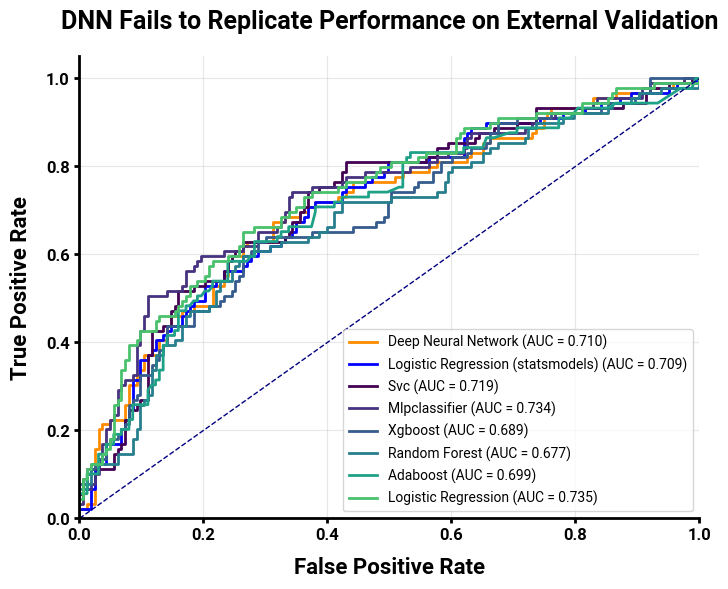

In [19]:
plot_combined_roc_curves(
    all_model_results=all_model_results,
    output_path=output_dir / "combined_validation_roc_curves.png",
    title="DNN Fails to Replicate Performance on External Validation",
)

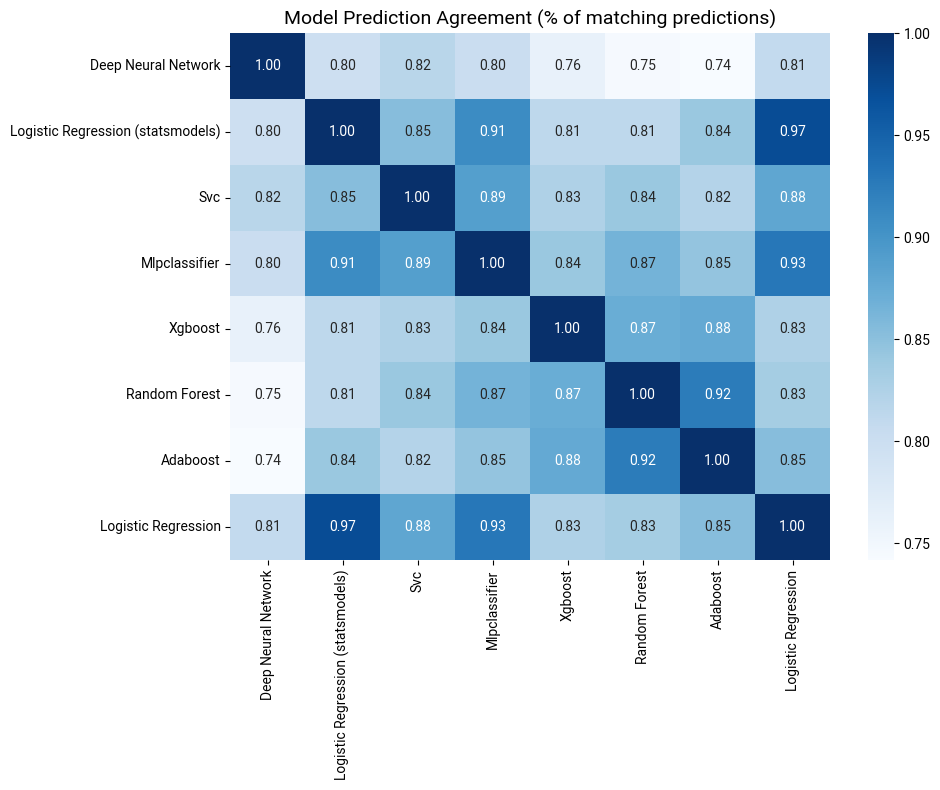

In [20]:
# Prepare the predictions dictionary
all_predictions = {}
for model_name, results in all_model_results.items():
    # Flatten predictions for the DNN model if needed
    if model_name == "Deep Neural Network":
        all_predictions[model_name] = results["predictions"].flatten()
    else:
        all_predictions[model_name] = results["predictions"]

# Call the function
plot_model_agreement_heatmap(
    all_predictions=all_predictions,
    output_path=output_dir / "combined_validation_model_agreement.png",
    title="Model Prediction Agreement (% of matching predictions)",
)

### Export Combined Dataframe For R Analysis

Validation cohort descriptive tables created using R package gtsummary

In [21]:
from src.config.constants import NUMERICAL_FEATURES

df_combined_x = pd.concat([X_spain, X_scotland, X_australia], ignore_index=True)
df_combined_y = pd.concat([y_spain, y_scotland, y_australia], ignore_index=True)
df_combined = pd.concat([df_combined_x, df_combined_y.rename("fatigue_outcome")], axis=1)

# Unscale numerical features
numerical_features = [
    col
    for col in NUMERICAL_FEATURES
    if col not in ["haematocrit", "ada_drug_level", "ifx_drug_level"]
]
df_combined[numerical_features] = scaler.inverse_transform(
    df_combined[numerical_features]
)

df_combined.to_csv(
    VALIDATION_COMBINED_DIR / "combined_validation_data.csv", index=False
)
